In [10]:
import matplotlib.pyplot as plt
import nltk
import spacy
import numpy as np
from nltk import WordNetLemmatizer, Counter
from nltk.corpus import brown
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
import import_ipynb
import wsd

In [11]:
lemmatizer = WordNetLemmatizer()
nlp = spacy.load('en_core_web_sm')

pronouns_persons = ['i', 'you', 'he', 'she', 'we', 'they', 'me']

pronouns_object = ['it']
ambiguous_terms = ['that', 'what', 'her']

person_supersense = 'noun.person'
entity_supersense = 'noun.entity'

In [12]:
def get_sentences_with_verb(verb):
    target_sentence = []
    for sentence in brown.sents():
        for word in sentence:
            if lemmatizer.lemmatize(word, 'v') == verb:
                # if has_subj_dobj(sentence, verb):
                target_sentence.append(' '.join(sentence))
    return target_sentence

In [13]:
def extract_subj_dobj(sentence, verb_base_form):
    token_s = nlp(sentence)
    for token in token_s:
        subj, dobj = '', ''
        if verb_base_form in token.text:
            for child in token.children:
                if child.dep_ == "nsubj":
                    # print('SOGGETTO : {}\n'.format(child.text))
                    subj = child.text
                if child.dep_ == "dobj":
                    # print('OGGETTO DIRETTO : {}\n'.format(child.text))
                    dobj = child.text
        if dobj != '' and subj != '':
            break
    return subj, dobj


In [14]:
def map_pronom_to_sense(word):
    if word.lower() in pronouns_persons:
        return person_supersense
    else:
        return entity_supersense


def is_pronom(word):
    pos_word = nltk.pos_tag(word_tokenize(word))
    return pos_word[0][1] == 'PRP'


def stringate_value(hypernom_subj, hypernom_dobj):
    return hypernom_subj.split('.')[1] + ':' + hypernom_dobj.split('.')[1]


def is_personal_noun(subj):
    char = subj[0:1]
    if len(wn.synsets(subj)) == 0 and char.isupper():
        return True
    return False


def take_second(elem):
    return elem[1]

In [15]:
def get_supersense(elem, sentence):
    hypernom, elem_disambigued  = '', None
    if is_pronom(elem):
        hypernom = map_pronom_to_sense(elem)
    elif is_personal_noun(elem):
        hypernom = person_supersense
    else:
        elem_disambigued = wsd.lesk_algorithm(elem, sentence)
    if elem_disambigued is not None:
        hypernom = elem_disambigued._lexname
    return hypernom

In [16]:
def get_semantic_cluster(sentences, verb_base_form):
    filler1, filler2 = [], []
    sentences_analyzed, semantic_type = 0, []
    for s in sentences:
        subj, dobj = extract_subj_dobj(s, verb_base_form)

        if subj != '' and dobj != '':
            if subj.lower() not in ambiguous_terms and dobj.lower() not in ambiguous_terms:
                hypernom_subj = get_supersense(subj, s)
                hypernom_dobj = get_supersense(dobj, s)

                if hypernom_dobj != '' and hypernom_subj != '':
                    sentences_analyzed += 1
                    filler1.append(hypernom_subj)
                    filler2.append(hypernom_dobj)
                    semantic_values = stringate_value(hypernom_subj, hypernom_dobj)
                    semantic_type.append(semantic_values)

    return semantic_type, sentences_analyzed

In [17]:
def plot_result(dataset, verb):
    # Add titles and axis names
    occurence, semantic_type = [], []
    for k in dataset:
        occurence.append(k[1])
        semantic_type.append(k[0].replace(':', '\n'))

    y_pos = np.arange(len(semantic_type))
    plt.bar(y_pos, occurence, align='center', alpha=0.5)
    plt.xticks(y_pos, semantic_type)
    plt.title('Semantic cluster of verb {}'.format(verb))
    plt.xlabel('Semantic types')
    plt.ylabel('Occurences')
    plt.show()



Current verb : eat

Plot verb eat


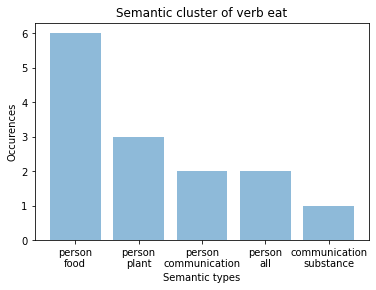


Sono state analizzate 24 frasi 
per il verbo: eat le cui coppie semantiche sono :

	< communication:substance > Count 1 
	< communication:quantity > Count 1 
	< quantity:body > Count 1 
	< person:plant > Count 3 
	< person:person > Count 1 
	< person:animal > Count 1 
	< group:plant > Count 1 
	< person:communication > Count 2 
	< entity:body > Count 1 
	< person:quantity > Count 1 
	< person:all > Count 2 
	< person:food > Count 6 
	< person:entity > Count 1 
	< animal:group > Count 1 
	< person:substance > Count 1 



Current verb : read

Plot verb read


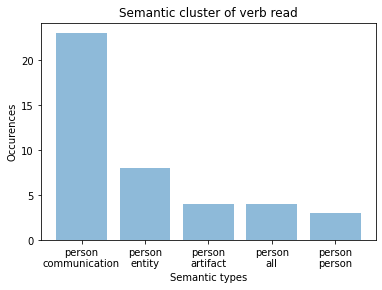


Sono state analizzate 65 frasi 
per il verbo: read le cui coppie semantiche sono :

	< person:communication > Count 23 
	< person:artifact > Count 4 
	< person:entity > Count 8 
	< group:communication > Count 1 
	< group:location > Count 1 
	< person:change > Count 1 
	< person:person > Count 3 
	< entity:person > Count 1 
	< person:cognition > Count 1 
	< person:attribute > Count 1 
	< all:quantity > Count 2 
	< person:time > Count 1 
	< person:all > Count 4 
	< quantity:possession > Count 1 
	< act:communication > Count 2 
	< quantity:entity > Count 2 
	< person:quantity > Count 1 
	< relation:time > Count 1 
	< group:state > Count 2 
	< group:stative > Count 1 
	< person:substance > Count 1 
	< person:event > Count 1 
	< person:location > Count 1 
	< group:person > Count 1 




In [18]:
verbs = ['eat', 'read']

for v in verbs:

    sentences = get_sentences_with_verb(v)
    print('\nCurrent verb : {}\n'.format(v))
    semantic_cluster, sentences_analyzed = get_semantic_cluster(sentences, v)
    print('Plot verb {}'.format(v))

    # Print stats
    sts_semantic_cluster = Counter(semantic_cluster)
    common_semantic_cluster = sts_semantic_cluster.most_common(5)
    plot_result(common_semantic_cluster, v)

    print('\nSono state analizzate {} frasi \nper il verbo: {} le cui coppie semantiche sono :\n'.format(sentences_analyzed, v))

    for s in sts_semantic_cluster:
        print('\t< {} > Count {} '.format(s, sts_semantic_cluster[s]))

    print('\n')
